In [26]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob

In [27]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Decomopt
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [28]:
uru.rd_set_image_size(300,300)

### Reading the data from Decomopt

See if they are valid or not

In [29]:
smi_list = []
with open('combined_smiles_decompopt.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in smi_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

print(len(smi_list))
len(standardized_smiles_list)

913


913

Convert SMILES and name of them to a dataframe

In [30]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...
3,CCCCC(C1=CC2=C(N3CCC(C)C3)N=[N+](C)C2=C1C(=O)O...
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...
...,...
908,NC1CC2C(N)CCCNC2C1O
909,O=C(O)C1C(O)CC(O)CC1CO
910,OC1OOC2CCC(O)(C1O)C2O
911,OCCC1(O)C(O)CCCCC1O


Add an RDKit molecule to the dataframe

In [31]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

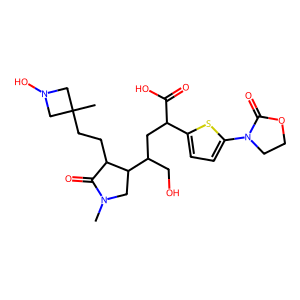

In [32]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [33]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                [O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]
1                            [O=C1NCc2ccccc2N1, c1cocn1]
2            [c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]
3      [C1=CC2=CN=[NH+]C2=C1, C1CCNC1, O=C1CCCCN1, C1...
4                     [c1cncnc1, C1CCCC1, O=c1cccc[nH]1]
                             ...                        
908                                     [C1CCC2CCCC2NC1]
909                                           [C1CCCCC1]
910                                    [C1CC2CCC(C2)OO1]
911                                          [C1CCCCCC1]
912                                          [C1CCCCCC1]
Name: ring_sytems, Length: 913, dtype: object

In [34]:
df.ring_sytems.values

array([list(['O=C1CCCN1', 'c1ccsc1', 'O=C1NCCO1', 'C1CNC1']),
       list(['O=C1NCc2ccccc2N1', 'c1cocn1']),
       list(['c1cn[nH]c1', 'C1=CCCCC1', 'c1ccccc1', 'c1ccccc1']),
       list(['C1=CC2=CN=[NH+]C2=C1', 'C1CCNC1', 'O=C1CCCCN1', 'C1CN1']),
       list(['c1cncnc1', 'C1CCCC1', 'O=c1cccc[nH]1']),
       list(['c1ccccc1', 'c1ccncc1', 'C1=NC2=NC=NC12']),
       list(['C1CN1', 'C1=NC=NCC1', 'c1ccccc1']),
       list(['c1cocn1', 'C1CCCCCC1', 'c1ccccc1']),
       list(['c1ccccc1', 'c1cncnc1']),
       list(['c1ccccc1', 'C1CCC2CCCOC2CC1']), list(['C1CCC2CCC(C1)C2']),
       list(['c1ccoc1', 'C1CCCC1']), list(['C1CC2CC2C1']),
       list(['c1cn[nH]c1', 'C1COC2CCCCC2C2CCCC2C1']),
       list(['O=C1CC2CCCC2C2=C1CC=CC2', 'C1CCOCC1']), list(['c1cncnc1']),
       list(['C1=CCCCCCCCCCCC1']), list(['O=C1CCCC(=O)CC1']),
       list(['C1NCC2C3C1N23', 'C1CCOC1', 'c1ccccc1']),
       list(['C1CNC2NCNC2C1']), list(['c1ncc2ncc-2c[nH]1', 'C1CCOC1']),
       list(['C1CNC2NNCC2N1']), list(['C1CCOCC1', 'c

See how many times each ring system occurs

In [35]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
8,c1ccccc1,304
14,C1CCCC1,60
30,C1CCOC1,59
19,C1CCCCCC1,56
16,c1ccncc1,50
...,...,...
213,C1=CC2=NC=C[N+]2=C1,1
449,C1=NN=C2CNCCC12,1
209,C=C1C=CCC1,1
208,C1=CC2CC2C2=CCC3CC4C=CC5C(C1)C2C35C4,1


View the ring system frequencies

In [36]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [37]:
ring_system_lookup = uru.RingSystemLookup.default()
res = df.mol.apply(ring_system_lookup.process_mol)

In [38]:
res

0      [(O=C1CCCN1, 14446), (c1ccsc1, 68146), (O=C1NC...
1            [(O=C1NCc2ccccc2N1, 842), (c1cocn1, 15605)]
2      [(c1cn[nH]c1, 85440), (C1=CCCCC1, 7200), (c1cc...
3      [(C1=CC2=CN=[NH+]C2=C1, 0), (C1CCNC1, 112428),...
4      [(c1cncnc1, 81465), (C1CCCC1, 30433), (O=c1ccc...
                             ...                        
908                                [(C1CCC2CCCC2NC1, 0)]
909                                  [(C1CCCCC1, 77480)]
910                               [(C1CC2CCC(C2)OO1, 0)]
911                                  [(C1CCCCCC1, 2594)]
912                                  [(C1CCCCCC1, 2594)]
Name: mol, Length: 913, dtype: object

In [39]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a8c6c93eb20>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,6154
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e42e0>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,842
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e4190>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,7200
3,CCCCC(C1=CC2=C(N3CCC(C)C3)N=[N+](C)C2=C1C(=O)O...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e4120>,"[C1=CC2=CN=[NH+]C2=C1, C1CCNC1, O=C1CCCCN1, C1...",C1=CC2=CN=[NH+]C2=C1,0
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e40b0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,11659
...,...,...,...,...,...
908,NC1CC2C(N)CCCNC2C1O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790dd0>,[C1CCC2CCCC2NC1],C1CCC2CCCC2NC1,0
909,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790e40>,[C1CCCCC1],C1CCCCC1,77480
910,OC1OOC2CCC(O)(C1O)C2O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790eb0>,[C1CC2CCC(C2)OO1],C1CC2CCC(C2)OO1,0
911,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790f20>,[C1CCCCCC1],C1CCCCCC1,2594


In [40]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [41]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Proton(s) added/removed; Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16] WARNING: Omitted undefined stereo

[20:36:16

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a8c6c93eb20>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,6154,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e42e0>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,842,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e4190>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,7200,InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...
3,CCCCC(C1=CC2=C(N3CCC(C)C3)N=[N+](C)C2=C1C(=O)O...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e4120>,"[C1=CC2=CN=[NH+]C2=C1, C1CCNC1, O=C1CCCCN1, C1...",C1=CC2=CN=[NH+]C2=C1,0,InChI=1S/C25H36N6O3/c1-4-5-6-15(19-8-7-18(23(3...
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e40b0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,11659,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...
...,...,...,...,...,...,...
882,NC1CC2C(N)CCCNC2C1O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790dd0>,[C1CCC2CCCC2NC1],C1CCC2CCCC2NC1,0,InChI=1S/C9H19N3O/c10-6-2-1-3-12-8-5(6)4-7(11)...
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790e40>,[C1CCCCC1],C1CCCCC1,77480,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...
884,OC1OOC2CCC(O)(C1O)C2O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790eb0>,[C1CC2CCC(C2)OO1],C1CC2CCC(C2)OO1,0,"InChI=1S/C7H12O6/c8-4-3-1-2-7(4,11)5(9)6(10)13..."
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790f20>,[C1CCCCCC1],C1CCCCCC1,2594,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...


How many molecules contains ring structure?

In [42]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a8c6c93eb20>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,6154,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e42e0>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,842,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e4190>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,7200,InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...
3,CCCCC(C1=CC2=C(N3CCC(C)C3)N=[N+](C)C2=C1C(=O)O...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e4120>,"[C1=CC2=CN=[NH+]C2=C1, C1CCNC1, O=C1CCCCN1, C1...",C1=CC2=CN=[NH+]C2=C1,0,InChI=1S/C25H36N6O3/c1-4-5-6-15(19-8-7-18(23(3...
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e40b0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,11659,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...
...,...,...,...,...,...,...
882,NC1CC2C(N)CCCNC2C1O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790dd0>,[C1CCC2CCCC2NC1],C1CCC2CCCC2NC1,0,InChI=1S/C9H19N3O/c10-6-2-1-3-12-8-5(6)4-7(11)...
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790e40>,[C1CCCCC1],C1CCCCC1,77480,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...
884,OC1OOC2CCC(O)(C1O)C2O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790eb0>,[C1CC2CCC(C2)OO1],C1CC2CCC(C2)OO1,0,"InChI=1S/C7H12O6/c8-4-3-1-2-7(4,11)5(9)6(10)13..."
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790f20>,[C1CCCCCC1],C1CCCCCC1,2594,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...


In [43]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a8c6c93eb20>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,6154,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e42e0>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,842,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e4190>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,7200,InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e40b0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,11659,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...
6,CC(F)CNC(=O)C1(ONC2C=NC(N)=NC2N)N(CCc2ccccc2)C...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7f0040>,"[C1CN1, C1=NC=NCC1, c1ccccc1]",C1=NC=NCC1,103,InChI=1S/C20H26FN7O6/c1-11(21)9-24-15(29)20(34...
...,...,...,...,...,...,...
880,CC1OCC(O)C(O)C(NO)C1O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790cf0>,[C1CCCOCC1],C1CCCOCC1,329,InChI=1S/C7H15NO5/c1-3-6(10)5(8-12)7(11)4(9)2-...
881,CC1(O)CN(O)C(O)C1N(O)NO,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790d60>,[C1CCNC1],C1CCNC1,112428,InChI=1S/C5H13N3O5/c1-5(10)2-7(12)4(9)3(5)8(13...
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790e40>,[C1CCCCC1],C1CCCCC1,77480,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790f20>,[C1CCCCCC1],C1CCCCCC1,2594,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...


### How many of them could pass PAINS filter?

Get a list of rules

In [44]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [45]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [46]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [47]:
reos.pandas_mols(df.mol)

  0%|          | 0/887 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,PAINS,catechol_A(92)
3,ok,ok
4,ok,ok
...,...,...
882,ok,ok
883,ok,ok
884,ok,ok
885,ok,ok


In [48]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/887 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a8c6c93eb20>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,6154,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...,ok,ok
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e42e0>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,842,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...,ok,ok
3,CCCCC(C1=CC2=C(N3CCC(C)C3)N=[N+](C)C2=C1C(=O)O...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e4120>,"[C1=CC2=CN=[NH+]C2=C1, C1CCNC1, O=C1CCCCN1, C1...",C1=CC2=CN=[NH+]C2=C1,0,InChI=1S/C25H36N6O3/c1-4-5-6-15(19-8-7-18(23(3...,ok,ok
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e40b0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,11659,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...,ok,ok
5,NC(=O)CCC(CC=C(C(=O)O)c1ccc(-c2cccnc2)cc1)C(F)...,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f7e4040>,"[c1ccccc1, c1ccncc1, C1=NC2=NC=NC12]",C1=NC2=NC=NC12,0,InChI=1S/C24H23FN6O3/c25-19(20-21-22(29-20)31-...,ok,ok
...,...,...,...,...,...,...,...,...
882,NC1CC2C(N)CCCNC2C1O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790dd0>,[C1CCC2CCCC2NC1],C1CCC2CCCC2NC1,0,InChI=1S/C9H19N3O/c10-6-2-1-3-12-8-5(6)4-7(11)...,ok,ok
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790e40>,[C1CCCCC1],C1CCCCC1,77480,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...,ok,ok
884,OC1OOC2CCC(O)(C1O)C2O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790eb0>,[C1CC2CCC(C2)OO1],C1CC2CCC(C2)OO1,0,"InChI=1S/C7H12O6/c8-4-3-1-2-7(4,11)5(9)6(10)13...",ok,ok
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a8c5f790f20>,[C1CCCCCC1],C1CCCCCC1,2594,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...,ok,ok


Test all filters from rd_filters

In [49]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/887 [00:00<?, ?it/s]

Glaxo 0.8421645997745209 ['Glaxo'] 747


  0%|          | 0/887 [00:00<?, ?it/s]

Dundee 0.37316798196166856 ['Dundee'] 331


  0%|          | 0/887 [00:00<?, ?it/s]

BMS 0.6956031567080045 ['BMS'] 617


  0%|          | 0/887 [00:00<?, ?it/s]

SureChEMBL 0.6865839909808342 ['SureChEMBL'] 609


  0%|          | 0/887 [00:00<?, ?it/s]

MLSMR 0.37767756482525366 ['MLSMR'] 335


  0%|          | 0/887 [00:00<?, ?it/s]

Inpharmatica 0.7294250281848929 ['Inpharmatica'] 647


  0%|          | 0/887 [00:00<?, ?it/s]

LINT 0.5073280721533259 ['LINT'] 450


### How many of them could pass filters suggested by Dr.Reymond?

In [24]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c510>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,6154,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...,True
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c580>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,842,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...,True
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c5f0>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,7200,InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...,True
3,CCCCC(C1=CC2=C(N3CCC(C)C3)N=[N+](C)C2=C1C(=O)O...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c660>,"[C1=CC2=CN=[NH+]C2=C1, C1CCNC1, O=C1CCCCN1, C1...",C1=CC2=CN=[NH+]C2=C1,0,InChI=1S/C25H36N6O3/c1-4-5-6-15(19-8-7-18(23(3...,True
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c6d0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,11659,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...,True
...,...,...,...,...,...,...,...
882,NC1CC2C(N)CCCNC2C1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5540>,[C1CCC2CCCC2NC1],C1CCC2CCCC2NC1,0,InChI=1S/C9H19N3O/c10-6-2-1-3-12-8-5(6)4-7(11)...,True
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b55b0>,[C1CCCCC1],C1CCCCC1,77480,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...,True
884,OC1OOC2CCC(O)(C1O)C2O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5620>,[C1CC2CCC(C2)OO1],C1CC2CCC(C2)OO1,0,"InChI=1S/C7H12O6/c8-4-3-1-2-7(4,11)5(9)6(10)13...",True
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5690>,[C1CCCCCC1],C1CCCCCC1,2594,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...,True


In [25]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c510>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,6154,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...,True
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c580>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,842,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...,True
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c5f0>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,7200,InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...,True
3,CCCCC(C1=CC2=C(N3CCC(C)C3)N=[N+](C)C2=C1C(=O)O...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c660>,"[C1=CC2=CN=[NH+]C2=C1, C1CCNC1, O=C1CCCCN1, C1...",C1=CC2=CN=[NH+]C2=C1,0,InChI=1S/C25H36N6O3/c1-4-5-6-15(19-8-7-18(23(3...,True
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c6d0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,11659,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...,True
...,...,...,...,...,...,...,...
882,NC1CC2C(N)CCCNC2C1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5540>,[C1CCC2CCCC2NC1],C1CCC2CCCC2NC1,0,InChI=1S/C9H19N3O/c10-6-2-1-3-12-8-5(6)4-7(11)...,True
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b55b0>,[C1CCCCC1],C1CCCCC1,77480,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...,True
884,OC1OOC2CCC(O)(C1O)C2O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5620>,[C1CC2CCC(C2)OO1],C1CC2CCC(C2)OO1,0,"InChI=1S/C7H12O6/c8-4-3-1-2-7(4,11)5(9)6(10)13...",True
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5690>,[C1CCCCCC1],C1CCCCCC1,2594,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...,True


### How many of them could pass RO5?

In [26]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c510>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,6154,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...,True,True
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c580>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,842,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...,True,False
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c5f0>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,7200,InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...,True,False
3,CCCCC(C1=CC2=C(N3CCC(C)C3)N=[N+](C)C2=C1C(=O)O...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c660>,"[C1=CC2=CN=[NH+]C2=C1, C1CCNC1, O=C1CCCCN1, C1...",C1=CC2=CN=[NH+]C2=C1,0,InChI=1S/C25H36N6O3/c1-4-5-6-15(19-8-7-18(23(3...,True,True
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c6d0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,11659,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...,True,True
...,...,...,...,...,...,...,...,...
882,NC1CC2C(N)CCCNC2C1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5540>,[C1CCC2CCCC2NC1],C1CCC2CCCC2NC1,0,InChI=1S/C9H19N3O/c10-6-2-1-3-12-8-5(6)4-7(11)...,True,True
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b55b0>,[C1CCCCC1],C1CCCCC1,77480,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...,True,True
884,OC1OOC2CCC(O)(C1O)C2O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5620>,[C1CC2CCC(C2)OO1],C1CC2CCC(C2)OO1,0,"InChI=1S/C7H12O6/c8-4-3-1-2-7(4,11)5(9)6(10)13...",True,True
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5690>,[C1CCCCCC1],C1CCCCCC1,2594,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...,True,True


In [27]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c510>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,6154,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...,True,True
3,CCCCC(C1=CC2=C(N3CCC(C)C3)N=[N+](C)C2=C1C(=O)O...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c660>,"[C1=CC2=CN=[NH+]C2=C1, C1CCNC1, O=C1CCCCN1, C1...",C1=CC2=CN=[NH+]C2=C1,0,InChI=1S/C25H36N6O3/c1-4-5-6-15(19-8-7-18(23(3...,True,True
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c6d0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,11659,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...,True,True
5,NC(=O)CCC(CC=C(C(=O)O)c1ccc(-c2cccnc2)cc1)C(F)...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c740>,"[c1ccccc1, c1ccncc1, C1=NC2=NC=NC12]",C1=NC2=NC=NC12,0,InChI=1S/C24H23FN6O3/c25-19(20-21-22(29-20)31-...,False,True
7,CC(C)Oc1oc(C(O)CC(O)O)nc1C(=O)C1CC(c2ccccc2)CC...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c820>,"[c1cocn1, C1CCCCCC1, c1ccccc1]",C1CCCCCC1,2594,InChI=1S/C25H30N2O7/c1-14(2)33-25-22(27-24(34-...,True,True
...,...,...,...,...,...,...,...,...
882,NC1CC2C(N)CCCNC2C1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5540>,[C1CCC2CCCC2NC1],C1CCC2CCCC2NC1,0,InChI=1S/C9H19N3O/c10-6-2-1-3-12-8-5(6)4-7(11)...,True,True
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b55b0>,[C1CCCCC1],C1CCCCC1,77480,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...,True,True
884,OC1OOC2CCC(O)(C1O)C2O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5620>,[C1CC2CCC(C2)OO1],C1CC2CCC(C2)OO1,0,"InChI=1S/C7H12O6/c8-4-3-1-2-7(4,11)5(9)6(10)13...",True,True
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5690>,[C1CCCCCC1],C1CCCCCC1,2594,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...,True,True


### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [28]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0      [(O=C1CCCN1, 1149270234), (c1ccsc1, 5148488832...
1      [(O=C1NCc2ccccc2N1, 2994422), (c1cocn1, 192773...
2      [(c1cn[nH]c1, 8081544476), (C1=CCCCC1, 1045888...
3      [(C1=CC2=CN=[NH+]C2=C1, 0), (C1CCNC1, 14763048...
4      [(c1cncnc1, 2861731550), (C1CCCC1, 5317217694)...
                             ...                        
882                                [(C1CCC2CCCC2NC1, 0)]
883                             [(C1CCCCC1, 4295567520)]
884                               [(C1CC2CCC(C2)OO1, 0)]
885                             [(C1CCCCCC1, 481701208)]
886                             [(C1CCCCCC1, 481701208)]
Name: mol, Length: 887, dtype: object

In [29]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c510>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,274873194,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...,True,True
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c580>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,2994422,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...,True,False
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c5f0>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,1045888108,InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...,True,False
3,CCCCC(C1=CC2=C(N3CCC(C)C3)N=[N+](C)C2=C1C(=O)O...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c660>,"[C1=CC2=CN=[NH+]C2=C1, C1CCNC1, O=C1CCCCN1, C1...",C1=CC2=CN=[NH+]C2=C1,0,InChI=1S/C25H36N6O3/c1-4-5-6-15(19-8-7-18(23(3...,True,True
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c6d0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,263027600,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...,True,True
...,...,...,...,...,...,...,...,...
882,NC1CC2C(N)CCCNC2C1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5540>,[C1CCC2CCCC2NC1],C1CCC2CCCC2NC1,0,InChI=1S/C9H19N3O/c10-6-2-1-3-12-8-5(6)4-7(11)...,True,True
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b55b0>,[C1CCCCC1],C1CCCCC1,4295567520,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...,True,True
884,OC1OOC2CCC(O)(C1O)C2O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5620>,[C1CC2CCC(C2)OO1],C1CC2CCC(C2)OO1,0,"InChI=1S/C7H12O6/c8-4-3-1-2-7(4,11)5(9)6(10)13...",True,True
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5690>,[C1CCCCCC1],C1CCCCCC1,481701208,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...,True,True


In [30]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [31]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c510>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,274873194,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...,True,True
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c580>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,2994422,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...,True,False
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c5f0>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,1045888108,InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...,True,False
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c6d0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,263027600,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...,True,True
7,CC(C)Oc1oc(C(O)CC(O)O)nc1C(=O)C1CC(c2ccccc2)CC...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c820>,"[c1cocn1, C1CCCCCC1, c1ccccc1]",C1CCCCCC1,481701208,InChI=1S/C25H30N2O7/c1-14(2)33-25-22(27-24(34-...,True,True
...,...,...,...,...,...,...,...,...
880,CC1OCC(O)C(O)C(NO)C1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5460>,[C1CCCOCC1],C1CCCOCC1,83787488,InChI=1S/C7H15NO5/c1-3-6(10)5(8-12)7(11)4(9)2-...,True,True
881,CC1(O)CN(O)C(O)C1N(O)NO,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b54d0>,[C1CCNC1],C1CCNC1,14763048450,InChI=1S/C5H13N3O5/c1-5(10)2-7(12)4(9)3(5)8(13...,True,False
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b55b0>,[C1CCCCC1],C1CCCCC1,4295567520,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...,True,True
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5690>,[C1CCCCCC1],C1CCCCCC1,481701208,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...,True,True


In [32]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c510>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,274873194,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...,True,True
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c580>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,2994422,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...,True,False
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c5f0>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,1045888108,InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...,True,False
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c6d0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,263027600,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...,True,True
6,CC(F)CNC(=O)C1(ONC2C=NC(N)=NC2N)N(CCc2ccccc2)C...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c7b0>,"[C1CN1, C1=NC=NCC1, c1ccccc1]",C1=NC=NCC1,38,InChI=1S/C20H26FN7O6/c1-11(21)9-24-15(29)20(34...,True,False
...,...,...,...,...,...,...,...,...
880,CC1OCC(O)C(O)C(NO)C1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5460>,[C1CCCOCC1],C1CCCOCC1,83787488,InChI=1S/C7H15NO5/c1-3-6(10)5(8-12)7(11)4(9)2-...,True,True
881,CC1(O)CN(O)C(O)C1N(O)NO,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b54d0>,[C1CCNC1],C1CCNC1,14763048450,InChI=1S/C5H13N3O5/c1-5(10)2-7(12)4(9)3(5)8(13...,True,False
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b55b0>,[C1CCCCC1],C1CCCCC1,4295567520,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...,True,True
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5690>,[C1CCCCCC1],C1CCCCCC1,481701208,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...,True,True


In [33]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c510>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,274873194,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...,True,True
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c580>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,2994422,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...,True,False
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c5f0>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,1045888108,InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...,True,False
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c6d0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,263027600,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...,True,True
6,CC(F)CNC(=O)C1(ONC2C=NC(N)=NC2N)N(CCc2ccccc2)C...,<rdkit.Chem.rdchem.Mol object at 0x7a1c7779c7b0>,"[C1CN1, C1=NC=NCC1, c1ccccc1]",C1=NC=NCC1,38,InChI=1S/C20H26FN7O6/c1-11(21)9-24-15(29)20(34...,True,False
...,...,...,...,...,...,...,...,...
880,CC1OCC(O)C(O)C(NO)C1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5460>,[C1CCCOCC1],C1CCCOCC1,83787488,InChI=1S/C7H15NO5/c1-3-6(10)5(8-12)7(11)4(9)2-...,True,True
881,CC1(O)CN(O)C(O)C1N(O)NO,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b54d0>,[C1CCNC1],C1CCNC1,14763048450,InChI=1S/C5H13N3O5/c1-5(10)2-7(12)4(9)3(5)8(13...,True,False
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b55b0>,[C1CCCCC1],C1CCCCC1,4295567520,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...,True,True
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x7a1c777b5690>,[C1CCCCCC1],C1CCCCCC1,481701208,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...,True,True


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [63]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0      [(O=C1CCCN1, 22764782), (c1ccsc1, 33752004), (...
1       [(O=C1NCc2ccccc2N1, 22638), (c1cocn1, 16874264)]
2      [(c1cn[nH]c1, 94875952), (C1=CCCCC1, 3763844),...
3      [(C1=CC2=CN=[NH+]C2=C1, 0), (C1CCNC1, 13678160...
4      [(c1cncnc1, 30067373), (C1CCCC1, 34084223), (O...
                             ...                        
882                                [(C1CCC2CCCC2NC1, 0)]
883                               [(C1CCCCC1, 40360716)]
884                               [(C1CC2CCC(C2)OO1, 0)]
885                               [(C1CCCCCC1, 2033754)]
886                               [(C1CCCCCC1, 2033754)]
Name: mol, Length: 887, dtype: object

In [64]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x75c66fb56a40>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,2258110,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...,True,True
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x75c64514ab90>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,22638,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...,True,False
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x75c64514ac00>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,3763844,InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...,True,False
3,CCCCC(C1=CC2=C(N3CCC(C)C3)N=[N+](C)C2=C1C(=O)O...,<rdkit.Chem.rdchem.Mol object at 0x75c64514ac70>,"[C1=CC2=CN=[NH+]C2=C1, C1CCNC1, O=C1CCCCN1, C1...",C1=CC2=CN=[NH+]C2=C1,0,InChI=1S/C25H36N6O3/c1-4-5-6-15(19-8-7-18(23(3...,True,True
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x75c64514ace0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,4043767,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...,True,True
...,...,...,...,...,...,...,...,...
882,NC1CC2C(N)CCCNC2C1O,<rdkit.Chem.rdchem.Mol object at 0x75c645163b50>,[C1CCC2CCCC2NC1],C1CCC2CCCC2NC1,0,InChI=1S/C9H19N3O/c10-6-2-1-3-12-8-5(6)4-7(11)...,True,True
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x75c645163bc0>,[C1CCCCC1],C1CCCCC1,40360716,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...,True,True
884,OC1OOC2CCC(O)(C1O)C2O,<rdkit.Chem.rdchem.Mol object at 0x75c645163c30>,[C1CC2CCC(C2)OO1],C1CC2CCC(C2)OO1,0,"InChI=1S/C7H12O6/c8-4-3-1-2-7(4,11)5(9)6(10)13...",True,True
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x75c645163ca0>,[C1CCCCCC1],C1CCCCCC1,2033754,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...,True,True


In [65]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [66]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CN1CC(C(CO)CC(C(=O)O)c2ccc(N3CCOC3=O)s2)C(CCC2...,<rdkit.Chem.rdchem.Mol object at 0x75c66fb56a40>,"[O=C1CCCN1, c1ccsc1, O=C1NCCO1, C1CNC1]",O=C1NCCO1,2258110,InChI=1S/C23H33N3O7S/c1-23(12-25(32)13-23)6-5-...,True,True
1,CCCOc1cc2c(cc1C(=O)NCC(NC(C)=O)C(O)CNc1ncc(C)o...,<rdkit.Chem.rdchem.Mol object at 0x75c64514ab90>,"[O=C1NCc2ccccc2N1, c1cocn1]",O=C1NCc2ccccc2N1,22638,InChI=1S/C22H30N6O6/c1-4-5-33-19-7-16-14(9-24-...,True,False
2,CC(=O)n1cc(C2C=C(O)CCC2)c(NC(=O)c2cc(C(C)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x75c64514ac00>,"[c1cn[nH]c1, C1=CCCCC1, c1ccccc1, c1ccccc1]",C1=CCCCC1,3763844,InChI=1S/C26H27N3O5/c1-15(17-7-4-3-5-8-17)19-1...,True,False
4,C=C(C)OC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)n1ccc(...,<rdkit.Chem.rdchem.Mol object at 0x75c64514ace0>,"[c1cncnc1, C1CCCC1, O=c1cccc[nH]1]",O=c1cccc[nH]1,4043767,InChI=1S/C25H38N6O3/c1-15(2)34-24(31-11-8-19(1...,True,True
7,CC(C)Oc1oc(C(O)CC(O)O)nc1C(=O)C1CC(c2ccccc2)CC...,<rdkit.Chem.rdchem.Mol object at 0x75c64514ae30>,"[c1cocn1, C1CCCCCC1, c1ccccc1]",C1CCCCCC1,2033754,InChI=1S/C25H30N2O7/c1-14(2)33-25-22(27-24(34-...,True,True
...,...,...,...,...,...,...,...,...
880,CC1OCC(O)C(O)C(NO)C1O,<rdkit.Chem.rdchem.Mol object at 0x75c645163a70>,[C1CCCOCC1],C1CCCOCC1,342648,InChI=1S/C7H15NO5/c1-3-6(10)5(8-12)7(11)4(9)2-...,True,True
881,CC1(O)CN(O)C(O)C1N(O)NO,<rdkit.Chem.rdchem.Mol object at 0x75c645163ae0>,[C1CCNC1],C1CCNC1,136781602,InChI=1S/C5H13N3O5/c1-5(10)2-7(12)4(9)3(5)8(13...,True,False
883,O=C(O)C1C(O)CC(O)CC1CO,<rdkit.Chem.rdchem.Mol object at 0x75c645163bc0>,[C1CCCCC1],C1CCCCC1,40360716,InChI=1S/C8H14O5/c9-3-4-1-5(10)2-6(11)7(4)8(12...,True,True
885,OCCC1(O)C(O)CCCCC1O,<rdkit.Chem.rdchem.Mol object at 0x75c645163ca0>,[C1CCCCCC1],C1CCCCCC1,2033754,InChI=1S/C9H18O4/c10-6-5-9(13)7(11)3-1-2-4-8(9...,True,True
